# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from mrmr import mrmr_regression

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

# Loading Datasets

In [5]:
df_train = pd.read_parquet('../data/processed/df_train_from_2.1_exploratory_data_analysis.parquet')
df_valid = pd.read_parquet('../data/processed/df_valid_from_2.1_exploratory_data_analysis.parquet')
df_oot = pd.read_parquet('../data/processed/df_oot_from_2.1_exploratory_data_analysis.parquet')

## Columns

In [6]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [7]:
df_valid.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [8]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 52161
Number of Cols: 147


In [10]:
print('Number of Rows: {}'.format(df_valid.shape[0]))
print('Number of Cols: {}'.format(df_valid.shape[1]))

Number of Rows: 25692
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_valid.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [14]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [15]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002799
customer_lng                                0.002799
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002492
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002511
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005272
distance_customer_seller_max                0.

In [16]:
df_valid.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002491
customer_lng                                0.002491
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002335
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002335
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004787
distance_customer_seller_max                0.

In [17]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [18]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_valid = df_valid.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [19]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_valid = df_valid.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [20]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [21]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.transform(X_valid)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [22]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)

X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.fit_transform(X_valid)
X_oot = cat_imputer.fit_transform(X_oot)

In [23]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_valid = rare_label_encoder.transform(X_valid)
X_oot = rare_label_encoder.transform(X_oot)

In [24]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_valid[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [25]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_valid[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Removing Features

In [26]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train = X_train.drop(columns=categorical_columns)
X_valid = X_valid.drop(columns=categorical_columns)
X_oot = X_oot.drop(columns=categorical_columns)

In [27]:
list_selected_features_rmrm = mrmr_regression(X=X_train, y=y_train[target], K=50)

100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [29]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "random_state": random_state,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=[(X_valid[list_selected_features_rmrm], y_valid[target])])
    
    pred = model.predict(X_valid[list_selected_features_rmrm])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.0077395791666640045, 'num_leaves': 771, 'subsample': 0.8194713778788048, 'colsample_bytree': 0.49444101254978284, 'min_data_in_leaf': 76}
Best RMSE: 8.109895549130561


In [30]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'random_state': random_state,
    'n_estimators': 900, 
    'learning_rate': 0.0077395791666640045, 
    'num_leaves': 771, 
    'subsample': 0.8194713778788048, 
    'colsample_bytree': 0.49444101254978284, 
    'min_data_in_leaf': 76}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=[(X_valid[list_selected_features_rmrm], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features_rmrm])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5519721794820026; RMSE: 6.730560034757038; MAE: 3.9699396485388587; MAPE: 18968589997950.176


In [31]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features_rmrm])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.32086634311661266; RMSE: 8.109895549130561; MAE: 5.0221394017636936; MAPE: 20127837476019.793


In [32]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.004683518880158943; RMSE: 5.793349423005902; MAE: 4.345261736239682; MAPE: 110726531907741.2


### Feature Selection

In [33]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

SelectFromModel(estimator=LGBMRegressor(bagging_freq=1,
                                        colsample_bytree=0.49444101254978284,
                                        learning_rate=0.0077395791666640045,
                                        metric='rmse', min_data_in_leaf=76,
                                        n_estimators=900, n_jobs=-1,
                                        num_leaves=771, objective='regression',
                                        random_state=42,
                                        subsample=0.8194713778788048,
                                        verbosity=-1))

In [34]:
list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['distance_customer_seller_min',
 'product_height_cm_max',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'freight_value_min',
 'freight_value_q25',
 'customer_lat',
 'order_approved_at_second',
 'customer_lng',
 'order_purchase_timestamp_month',
 'product_length_cm_min',
 'product_weight_g_min',
 'payment_value_max',
 'product_weight_g_q25',
 'payment_value_q75',
 'product_length_cm_q25',
 'payment_value_mean',
 'order_approved_at_month',
 'product_height_cm_min',
 'payment_value_q25']

In [35]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5315530303197222; RMSE: 6.882225969649428; MAE: 4.088481886087633; MAPE: 19152556988258.934


In [36]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3143419311560387; RMSE: 8.148758167814936; MAE: 5.059934190282089; MAPE: 19967180947438.98


In [37]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.0038085328844693622; RMSE: 5.795895339874195; MAE: 4.358428255455135; MAPE: 112090087890182.53


### Second Hyperparamenter Tuning

In [38]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 700, 'learning_rate': 0.009733990572515222, 'num_leaves': 308, 'subsample': 0.446051252156232, 'colsample_bytree': 0.595609903321796, 'min_data_in_leaf': 35}
Best RMSE: 8.160611499816945


In [39]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'random_state': random_state,
    'n_estimators': 700, 
    'learning_rate': 0.009733990572515222, 
    'num_leaves': 308, 
    'subsample': 0.446051252156232, 
    'colsample_bytree': 0.595609903321796, 
    'min_data_in_leaf': 35}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.524943639687599; RMSE: 6.9306071076247004; MAE: 4.184020590499209; MAPE: 22247273146175.223


In [40]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3119964638795033; RMSE: 8.162683715750893; MAE: 5.074775888606123; MAPE: 21196256340731.97


In [41]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.00011787044534039559; RMSE: 5.806621650347973; MAE: 4.375557139853486; MAPE: 116641214882085.39


## CatBoost Regressor

### First Hyperparameter Tuning

In [48]:
def objective(trial):
    
    params = {
        "random_state": random_state,
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=(X_valid[list_selected_features_rmrm], y_valid[target]))
    
    pred = model.predict(X_valid[list_selected_features_rmrm])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.08100298852155415, 'depth': 7, 'subsample': 0.8661036882987047, 'colsample_bylevel': 0.24031193020290004, 'min_data_in_leaf': 3}
Best RMSE: 8.188712257405443


In [50]:
params = {
    'random_state': random_state,
    'iterations': 1000,
    'learning_rate': 0.08100298852155415, 
    'depth': 7, 
    'subsample': 0.8661036882987047, 
    'colsample_bylevel': 0.24031193020290004, 
    'min_data_in_leaf': 3}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=(X_valid[list_selected_features_rmrm], y_valid[target]))

y_train['pred'] = cat.predict(X_train[list_selected_features_rmrm])
get_metrics(y_train[target], y_train['pred'])

R2: 0.4965392556222771; RMSE: 7.134795305691368; MAE: 4.593250056116276; MAPE: 22635888688659.832


In [51]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features_rmrm])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3076017621561621; RMSE: 8.188712257405443; MAE: 5.0967355484497885; MAPE: 19955116831498.305


In [52]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.012108299660609334; RMSE: 5.771700595919509; MAE: 4.319888330346425; MAPE: 114398235377021.73


### Feature Selection

In [53]:
sfm = SelectFromModel(estimator=CatBoostRegressor(**params, silent=True), max_features=50)
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7fc66e431040>,
                max_features=50)

In [55]:
list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state_te',
 'distance_customer_seller_min',
 'product_height_cm_max',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q75',
 'distance_customer_seller_max',
 'freight_value_min',
 'customer_lat',
 'order_approved_at_second',
 'customer_lng',
 'order_purchase_timestamp_month',
 'order_approved_at_month',
 'product_height_cm_min']

In [58]:
cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.401683530079332; RMSE: 7.7779328617341426; MAE: 4.930718695242681; MAPE: 24831449885723.13


In [59]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.2922374743972146; RMSE: 8.279067353863617; MAE: 5.168343333479978; MAPE: 21368543525107.28


In [60]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.01562574635271441; RMSE: 5.761416192927431; MAE: 4.331823231319647; MAPE: 115200264103400.02


### Second Hyperparameter Tuning

In [62]:
def objective(trial):
    
    params = {
        "random_state": random_state,
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=(X_valid[list_selected_features], y_valid[target]))
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.03744525650654855, 'depth': 10, 'subsample': 0.6786352815329565, 'colsample_bylevel': 0.16736990830254292, 'min_data_in_leaf': 83}
Best RMSE: 8.257052011621719


In [63]:
params = {
    'random_state': random_state,
    'iterations': 1000,
    'learning_rate': 0.03744525650654855, 
    'depth': 10, 
    'subsample': 0.6786352815329565, 
    'colsample_bylevel': 0.16736990830254292, 
    'min_data_in_leaf': 83}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.40423475286108623; RMSE: 7.761332585263771; MAE: 4.901478575809634; MAPE: 24859646379941.145


In [64]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.29599657347298525; RMSE: 8.257052011621719; MAE: 5.158166414762686; MAPE: 21108312732343.133


In [65]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.02717788777979857; RMSE: 5.7275098214346345; MAE: 4.31933067131343; MAPE: 118121392414448.3


## XGBoost Regressor

### First Hyperparameter Tuning

In [67]:
def objective(trial):
    
    params = {
        "random_state": random_state,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=[(X_valid[list_selected_features_rmrm], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_selected_features_rmrm])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.011557445672903701, 'max_depth': 8, 'subsample': 0.7201384429538236, 'colsample_bytree': 0.35930370452732896, 'min_child_weight': 6}
Best RMSE: 8.158947425814656


In [69]:
params = {
    'random_state': random_state,
    'n_estimators': 900, 
    'learning_rate': 0.011557445672903701, 
    'max_depth': 8, 
    'subsample': 0.7201384429538236, 
    'colsample_bytree': 0.35930370452732896, 
    'min_child_weight': 6}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features_rmrm], y_train[target], eval_set=[(X_valid[list_selected_features_rmrm], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features_rmrm])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5165179150467683; RMSE: 6.991798509345917; MAE: 4.416370431993506; MAPE: 22919318417799.027


In [70]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features_rmrm])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3126261568736345; RMSE: 8.158947425814656; MAE: 5.066438381933227; MAPE: 21332498903351.16


In [71]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.017128629058541622; RMSE: 5.75701642314619; MAE: 4.337754339984186; MAPE: 114354288307440.83


### Feature Selecion

In [73]:
sfm = SelectFromModel(estimator=XGBRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.35930370452732896,
                                       device=None, early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.011557445672903701,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=8,
                                       max_leaves=None, min_child_weight=6,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=900,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=42, ...))

In [74]:
list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state_te',
 'distance_customer_seller_min',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'customer_state_ce',
 'distance_customer_seller_max',
 'customer_lat',
 'order_purchase_timestamp_month',
 'order_approved_at_month']

In [75]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.34510678777022763; RMSE: 8.137367979859407; MAE: 5.080179791401958; MAPE: 27439226381575.957


In [76]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.27302053638611534; RMSE: 8.390709881500669; MAE: 5.285181546571302; MAPE: 23959825577344.06


In [77]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.04423766176265331; RMSE: 5.677067819022736; MAE: 4.259136935315427; MAPE: 122722433771180.16


### Second Hyperparameter Tuning

In [78]:
def objective(trial):
    
    params = {
        "random_state": random_state,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 700, 'learning_rate': 0.006953125213601284, 'max_depth': 7, 'subsample': 0.3970156648419698, 'colsample_bytree': 0.686190078356033, 'min_child_weight': 13}
Best RMSE: 8.357029267138662


In [79]:
params = {
    'eandom_state': random_state,
    'n_estimators': 700, 
    'learning_rate': 0.006953125213601284, 
    'max_depth': 7, 
    'subsample': 0.3970156648419698, 
    'colsample_bytree': 0.686190078356033, 
    'min_child_weight': 13}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.3043442697451162; RMSE: 8.386792430174403; MAE: 5.212458239402309; MAPE: 28605020698791.76


In [80]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.2780408268174369; RMSE: 8.361687895153638; MAE: 5.267032718251989; MAPE: 24636454904029.29


In [81]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.04529149425786083; RMSE: 5.673937161768885; MAE: 4.307496572664808; MAPE: 126194061746936.53


# Result Analysis

## Final Model

In [94]:
list_selected_features = [
    'distance_customer_seller_min',
    'product_height_cm_max',
    'distance_customer_seller_q25',
    'distance_customer_seller_mean',
    'freight_value_min',
    'freight_value_q25',
    'customer_lat',
    'order_approved_at_second',
    'customer_lng',
    'order_purchase_timestamp_month',
    'product_length_cm_min',
    'product_weight_g_min',
    'payment_value_max',
    'product_weight_g_q25',
    'payment_value_q75',
    'product_length_cm_q25',
    'payment_value_mean',
    'order_approved_at_month',
    'product_height_cm_min',
    'payment_value_q25']

params = {
    'random_state': random_state,
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 700, 
    'learning_rate': 0.009733990572515222, 
    'num_leaves': 308, 
    'subsample': 0.446051252156232, 
    'colsample_bytree': 0.595609903321796, 
    'min_data_in_leaf': 35}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.524311392978126; RMSE: 6.935217504342779; MAE: 4.184207387234653; MAPE: 22044786399025.656


In [95]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3123457389398867; RMSE: 8.160611499816945; MAE: 5.0746923994902025; MAPE: 21440187631475.973


In [96]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.004981594869233774; RMSE: 5.8214098972344415; MAE: 4.384367958664138; MAPE: 116131398180752.03


### Feature Importances

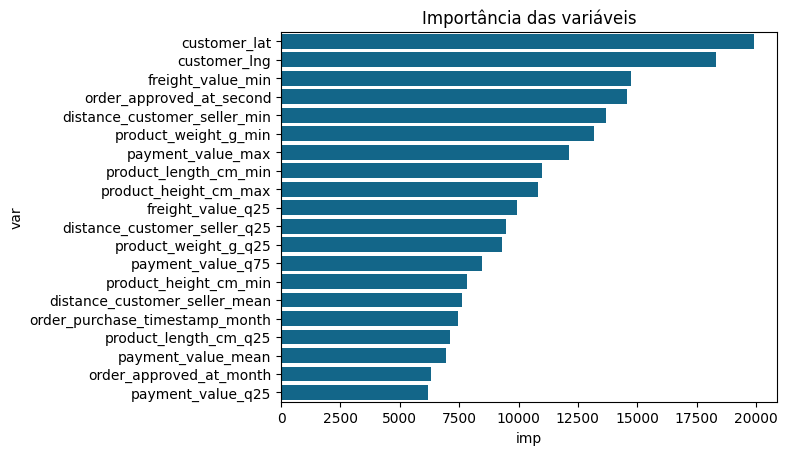

In [97]:
imp = pd.DataFrame(lgbm.feature_importances_, X_train[list_selected_columns].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp)

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [99]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[list_selected_features])

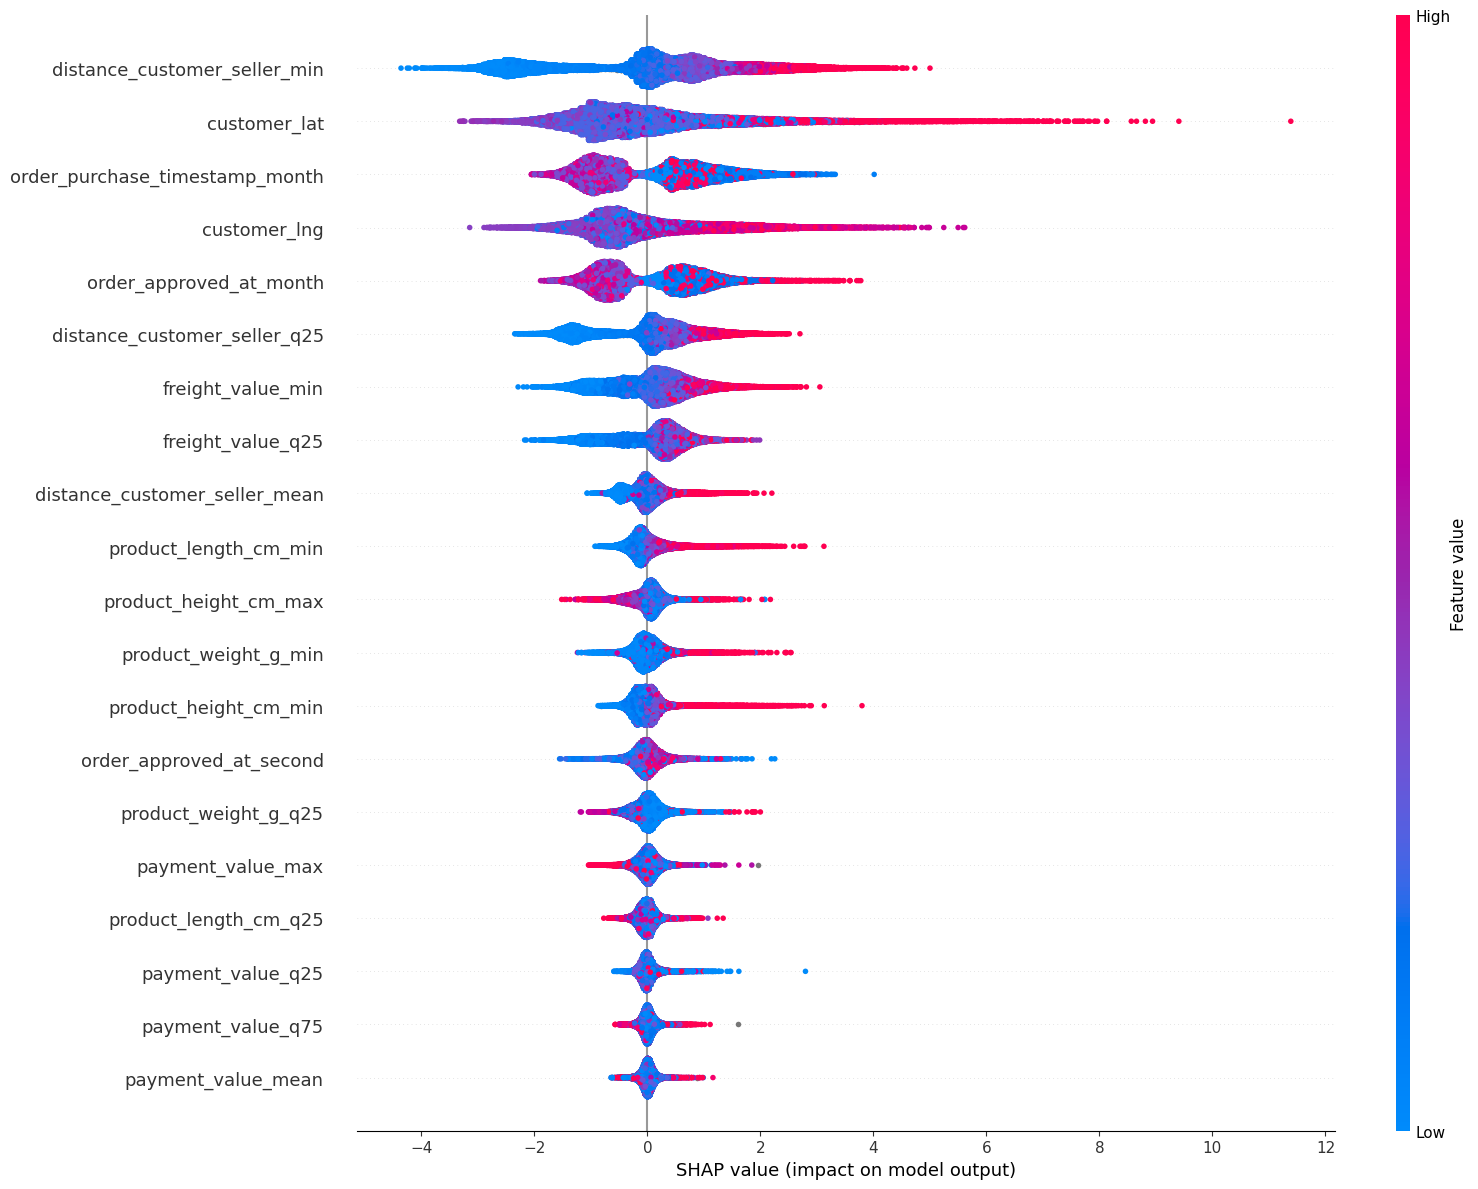

,index,impact
0,distance_customer_seller_min,1.212139
6,customer_lat,0.991230
9,order_purchase_timestamp_month,0.892993
8,customer_lng,0.833788
17,order_approved_at_month,0.761015
2,distance_customer_seller_q25,0.654345
4,freight_value_min,0.555542
5,freight_value_q25,0.503009
3,distance_customer_seller_mean,0.245496
10,product_length_cm_min,0.229196


In [100]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df.head(15))

## Analysis of Estimated Values

### Train Values

In [101]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2710958645968153; RMSE: 15.15362181073755; MAE: 12.798987749467994; MAPE: 63632846865898.91


In [102]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.524311392978126; RMSE: 6.935217504342779; MAE: 4.184207387234653; MAPE: 22044786399025.656


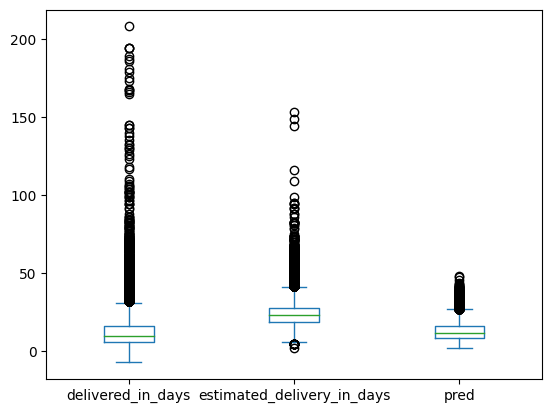

In [103]:
y_train.plot(kind='box');

### Valid Values

In [104]:
get_metrics(y_valid[target], y_valid['estimated_delivery_in_days'])

R2: -1.3023139893957243; RMSE: 14.932066313490298; MAE: 12.686517203798848; MAPE: 58722788228598.95


In [105]:
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3123457389398867; RMSE: 8.160611499816945; MAE: 5.0746923994902025; MAPE: 21440187631475.973


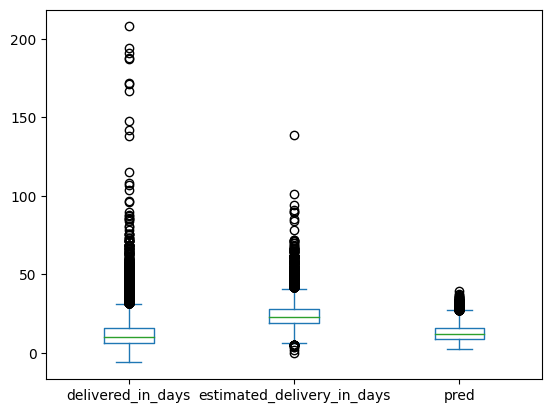

In [106]:
y_valid.plot(kind='box');

### OoT Values

In [107]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [108]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.004981594869233774; RMSE: 5.8214098972344415; MAE: 4.384367958664138; MAPE: 116131398180752.03


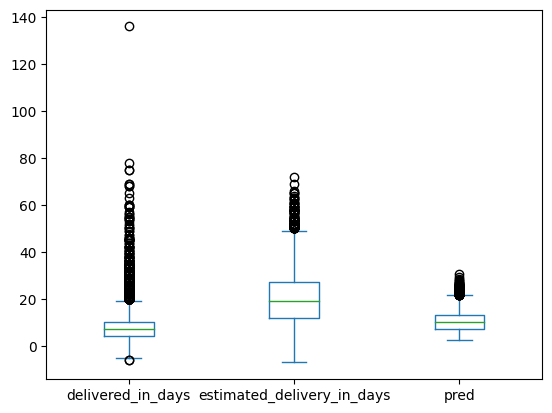

In [109]:
y_oot.plot(kind='box');

### Metrics over Time

In [110]:
df_aux = pd.concat([df_valid[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_valid, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

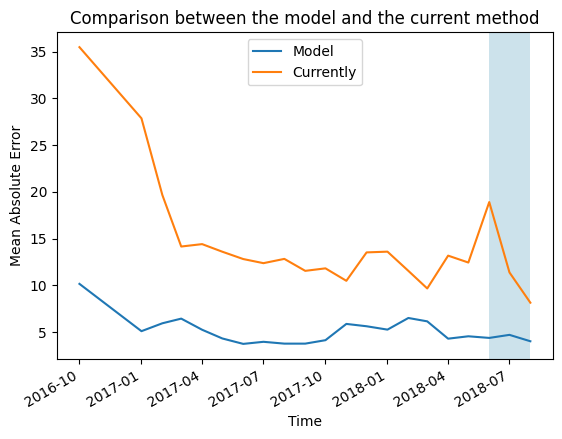

In [111]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

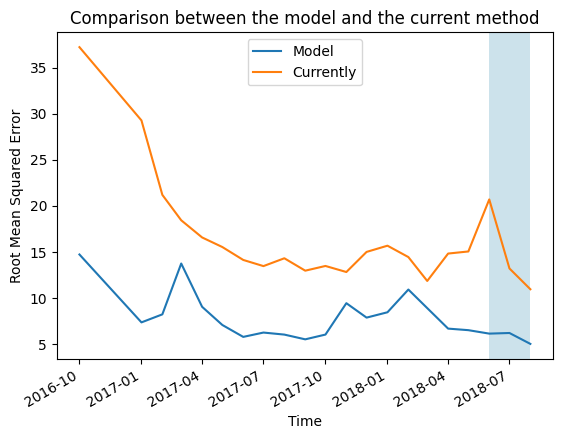

In [112]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');